#Welcome


In this notebook I will be training various machine learning models to perform classification. I will be working with a dataset where features are information about patients and the dependant variable is information if they have heart disease.

I'll be using Spark on Databricks platform for data preprocessing and model training. Databricks have a nice integration with MLFlow and I'm going to use it for model tracking. For hyperparameter tuning I'll be using Hyperopt.

This notebook is a 'remake' of previous notebook which I produced using Google Colab & RAPISD (SKLearn with GPU support). My main goal is to show my familiarity with Spark&Databricks workflow.

Using Spark MLLib for such a small dataset is not an optimal solution, using sklearn model training would probably be faster but as I said this notebook is for demonstrating my Spark skills.   

###Below is a short description of every feature

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
import pyspark.pandas as ps
import numpy as np
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import col, when
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
import mlflow
import mlflow.spark
from mlflow.tracking.client import MlflowClient
from mlflow.models.signature import infer_signature
from pyspark.ml.classification import RandomForestClassifier
from hyperopt.early_stop import no_progress_loss
from pyspark.ml.feature import VectorIndexer
from xgboost.spark import SparkXGBClassifier

mlflow.autolog(disable=True)

In [ ]:
spdf = spark.read.csv('dbfs:/FileStore/tables/heart.csv', inferSchema=True, header=True)
display(spdf.limit(10))

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [ ]:
spdf.write.mode('overwrite').format('delta').save('dbfs:/FileStore/tables/heart.delta')

In [ ]:
spdf = spark.read.format('delta').load('dbfs:/FileStore/tables/heart.delta')

I'll use Databricks data profiling to take a first look at the data and then inspect it further

In [ ]:
#display(spdf)

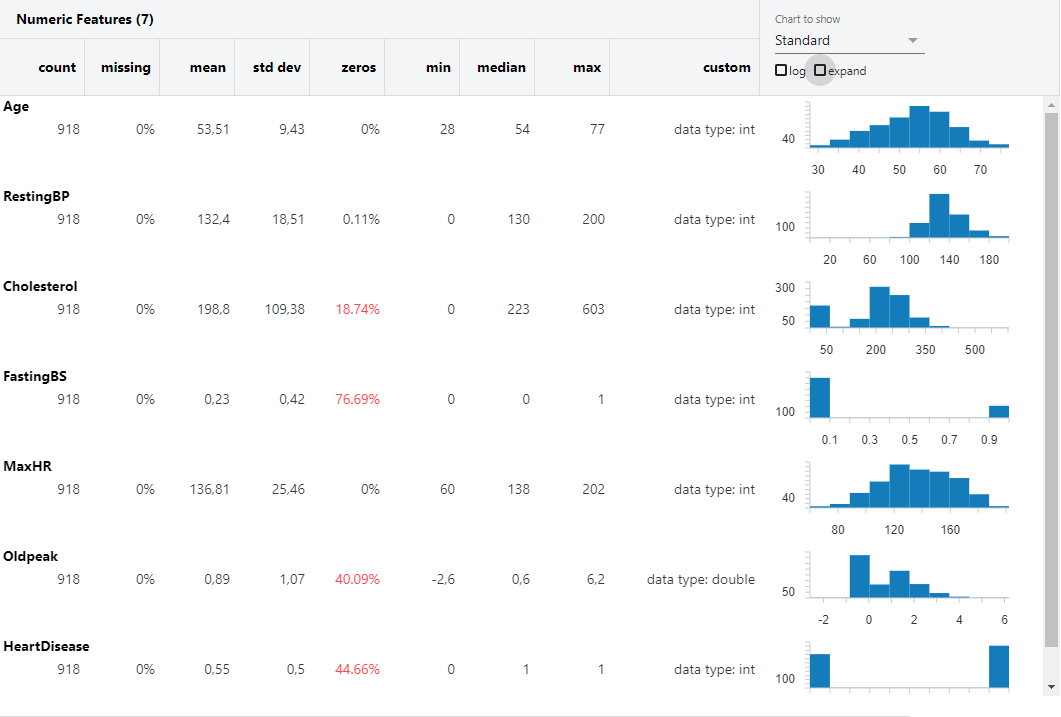

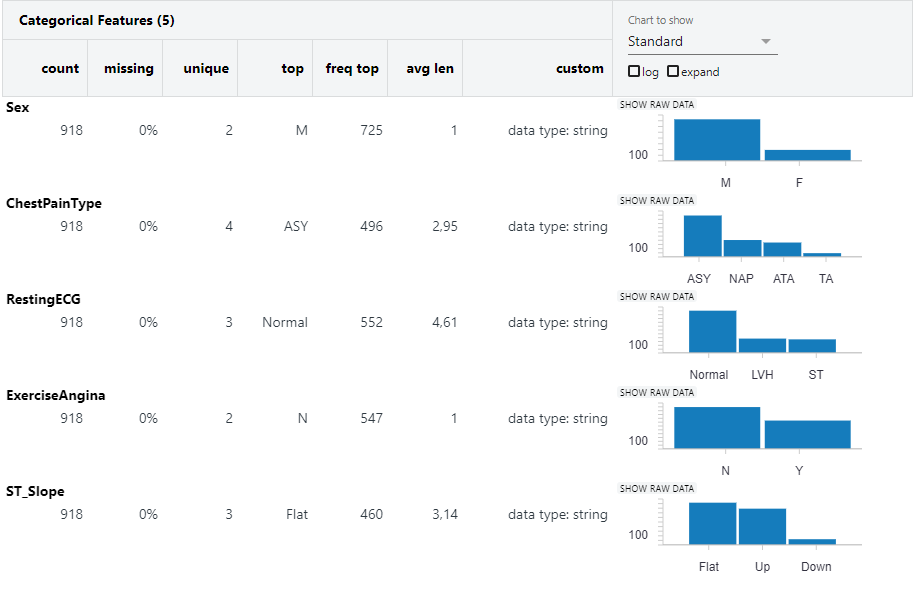

Target variable is pretty balanced which is good

In [ ]:
categorical_numeric = ['FastingBS']

categorical = ['ChestPainType', 'Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [ ]:
psdf = ps.DataFrame(spdf)

I have noticed that almost 19% of cholesterol column values are zeros, these 0 should be missing values rather than actual 0 so i'm going to change them to np.nan.

In [ ]:
psdf['Cholesterol'] = psdf['Cholesterol'].apply(lambda x: np.nan if x == 0 else x)

In [ ]:
spdf = psdf.to_spark()

I've also noticed than minimal value in RestingBP column is 0 which is probably because of a missing value rather than actual measurement of 0.

In [ ]:
#display(spdf.select('RestingBP'))

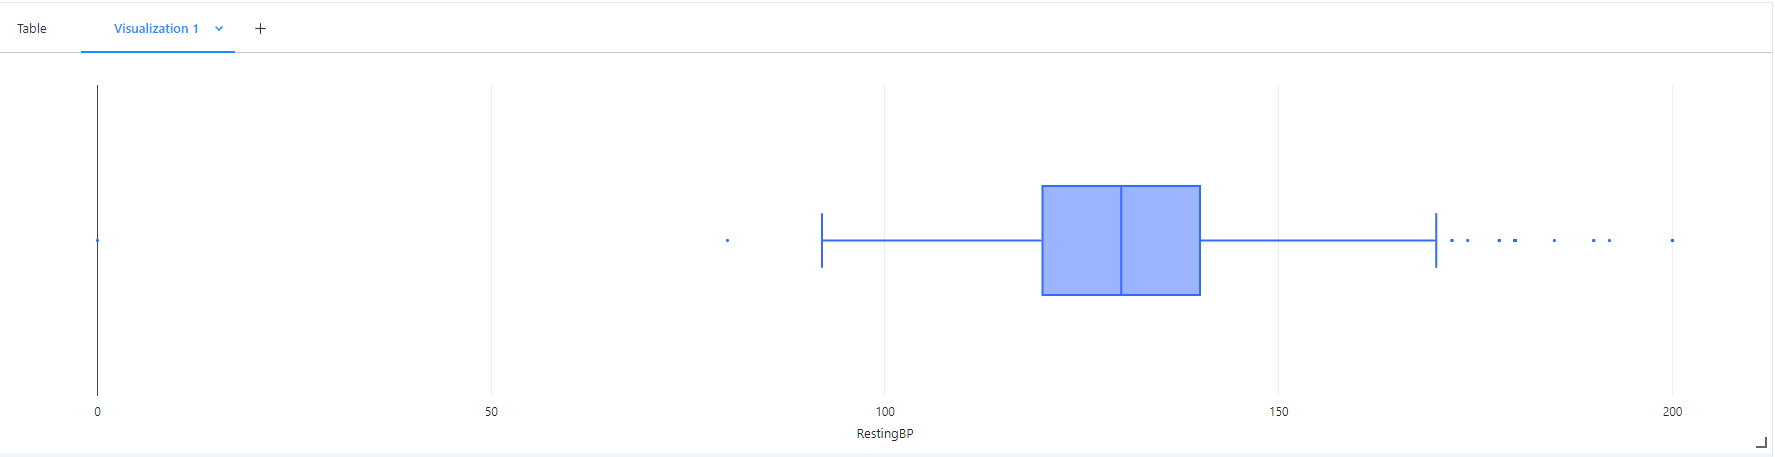

In [ ]:
psdf = ps.DataFrame(spdf)
psdf = psdf[psdf['RestingBP'] > 0]

In [ ]:
spdf = psdf.to_spark()

There is a much larger percentage of men (63.1) than women (25.9) that have a heart disease.

In [ ]:
display(spdf.crosstab('Sex', 'HeartDisease'))

Sex_HeartDisease,0,1
F,143,50
M,267,457


Output can only be rendered in Databricks

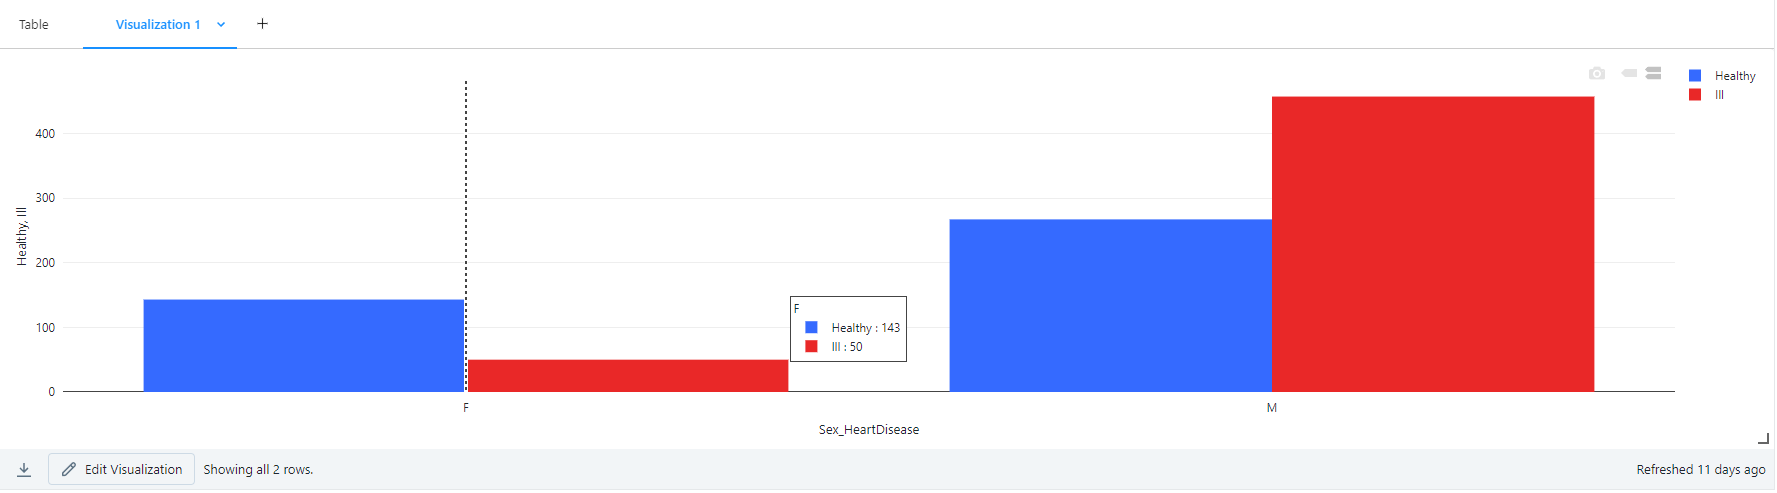

ATA and NAP chest pain types have a larger percentage of healthy people TA is ballanced while ASY has a larger percentage of ill people.

In [ ]:
display(spdf.crosstab('ChestPainType', 'HeartDisease'))

ChestPainType_HeartDisease,0,1
NAP,131,71
ATA,149,24
TA,26,20
ASY,104,392


Output can only be rendered in Databricks

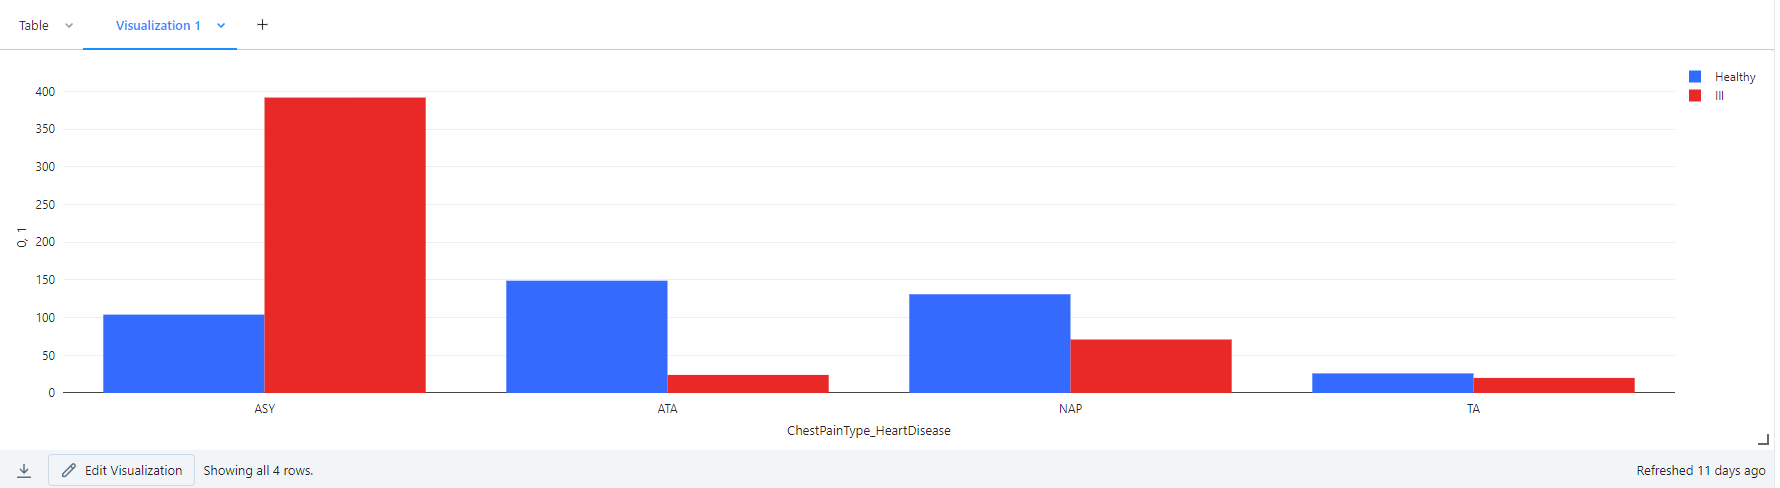

All of RestingECG categories have a larger percentage of ill people. In 'Normal' category there is only about 5% more ill people than healthy while it's about 25% and 50% for LVH and ST categories respectfully.

In [ ]:
display(spdf.crosstab('RestingECG', 'HeartDisease'))

RestingECG_HeartDisease,0,1
LVH,82,106
Normal,267,284
ST,61,117


Output can only be rendered in Databricks

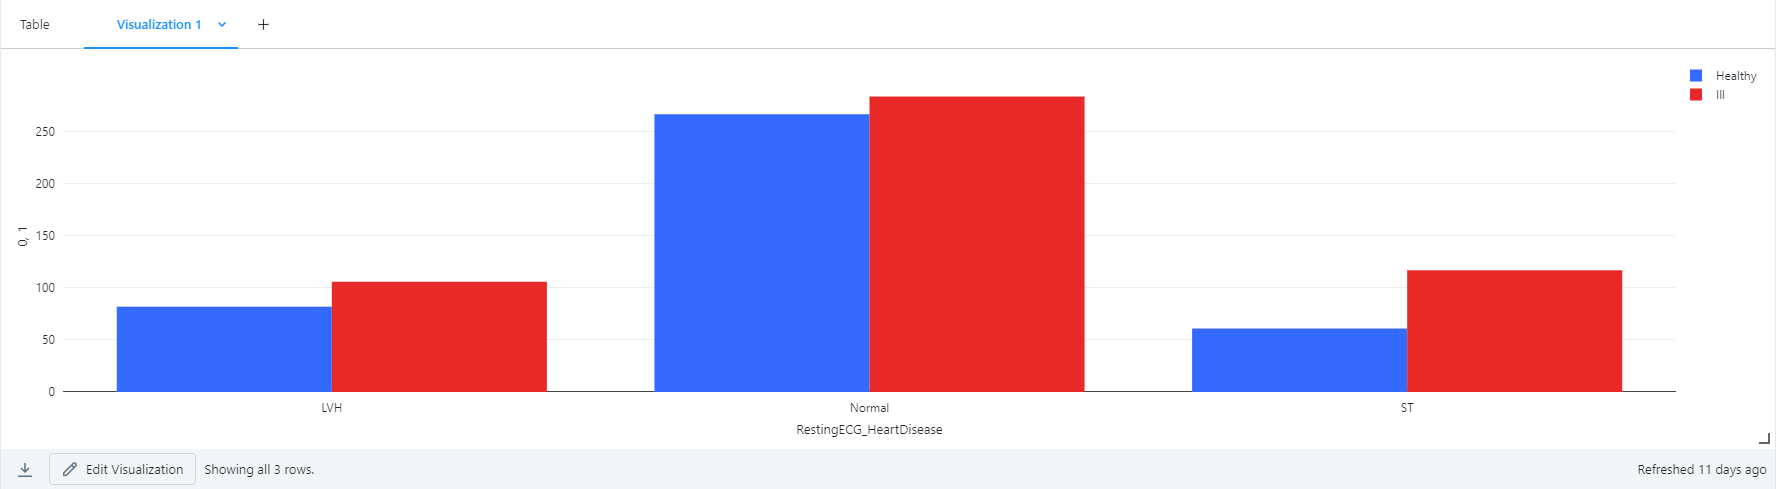

Percentage of people with heart disease is much larger amongst these people that have exercise-induced angina.

In [ ]:
display(spdf.crosstab('ExerciseAngina', 'HeartDisease'))

ExerciseAngina_HeartDisease,0,1
Y,55,316
N,355,191


Output can only be rendered in Databricks

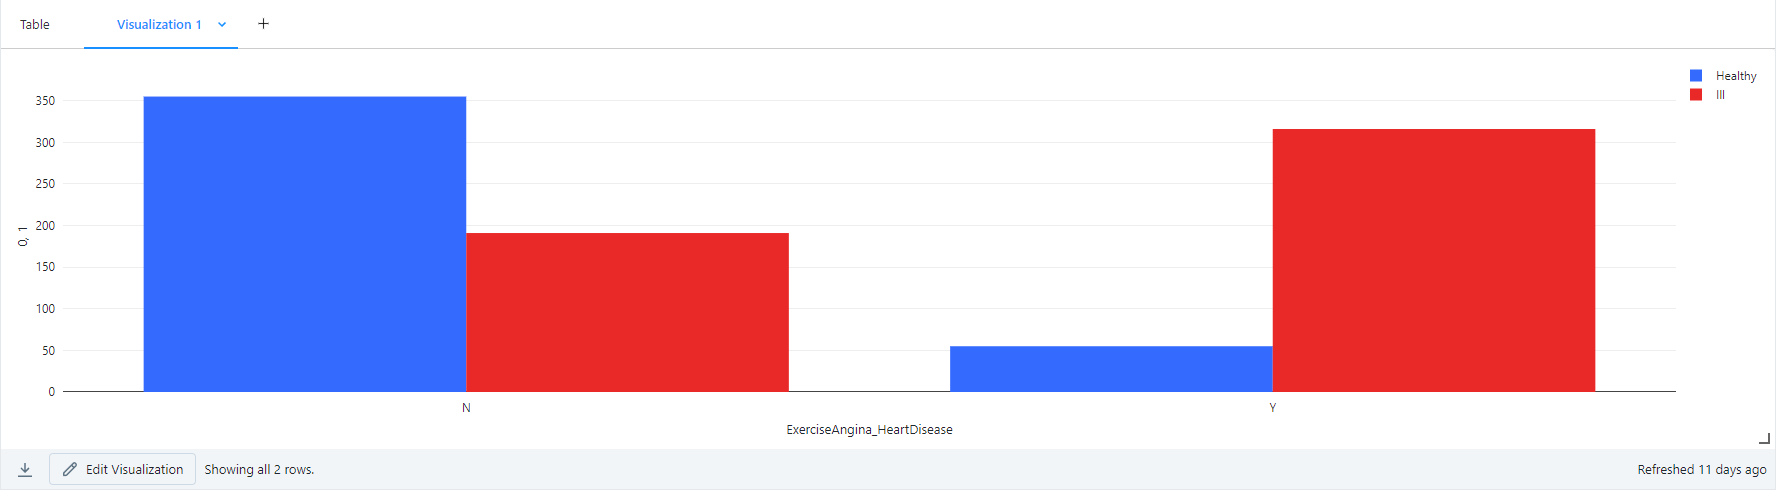

For Down and Flat categories of St Slope there is over 4 times more ill that healthy people and in Up category it's the opposite there is 4 times less ill people.

In [ ]:
display(spdf.crosstab('ST_Slope', 'HeartDisease'))

ST_Slope_HeartDisease,0,1
Flat,79,380
Up,317,78
Down,14,49


Output can only be rendered in Databricks

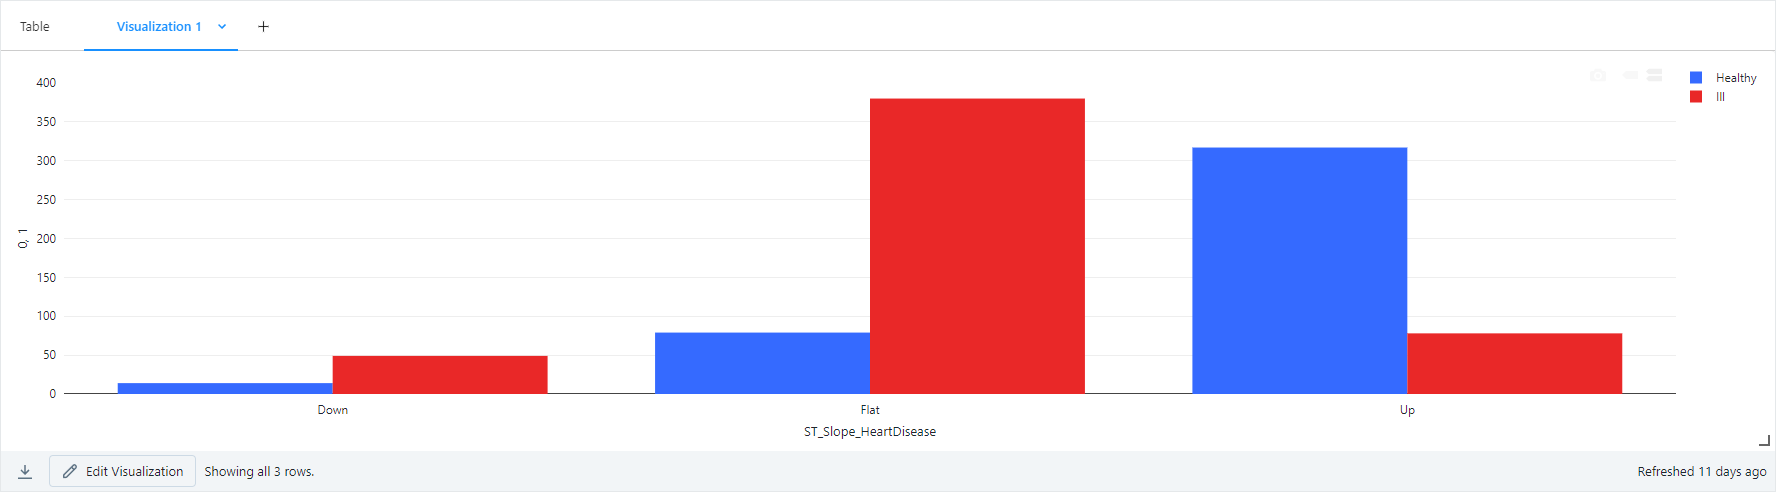

There is a large discrepancy in favour of ill people for category 1 of FastingBS and it's almost balanced for category 0.

In [ ]:
display(spdf.crosstab('FastingBS', 'HeartDisease'))

FastingBS_HeartDisease,0,1
0,366,337
1,44,170


Output can only be rendered in Databricks

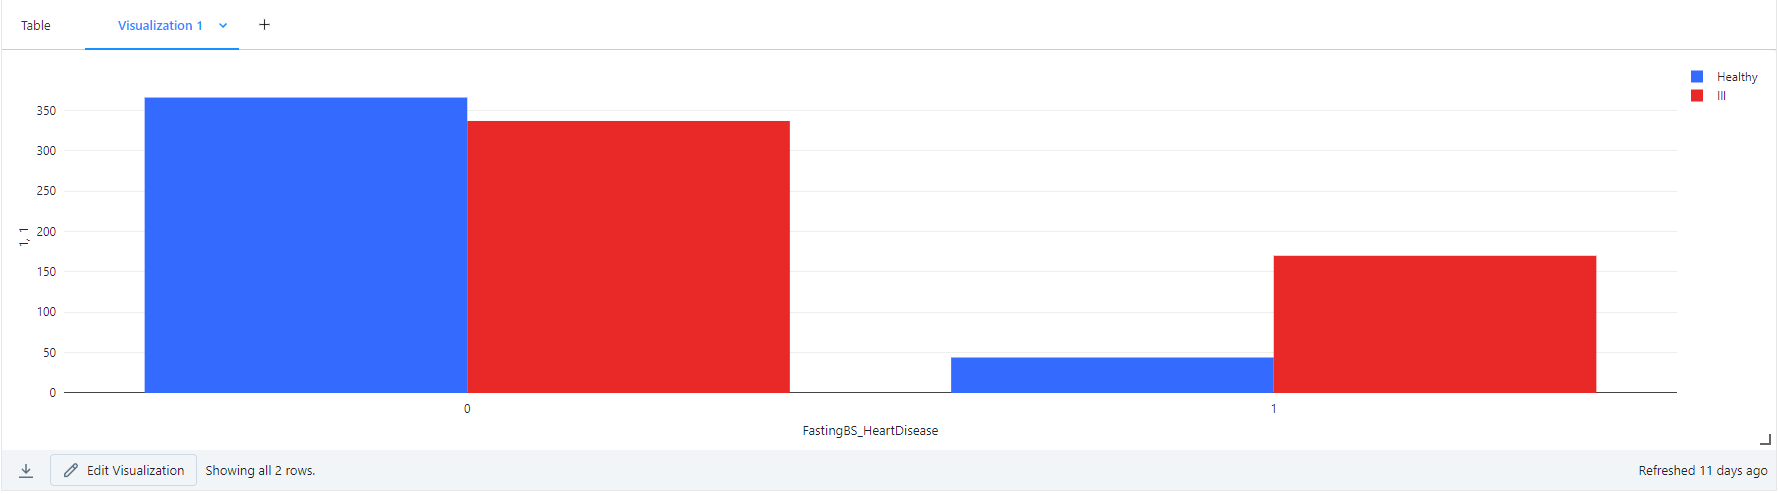

In [ ]:
#display(spdf.select('Age', 'HeartDisease'))

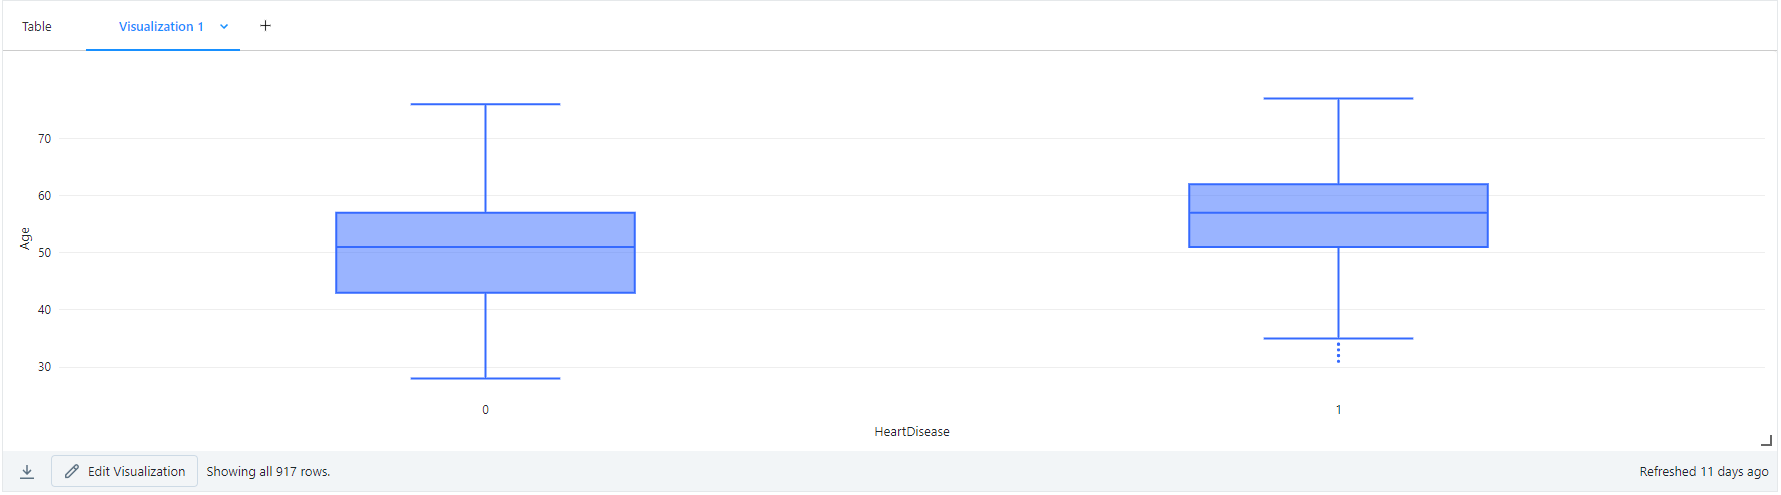

In [ ]:
#display(spdf.select('RestingBP', 'HeartDisease'))

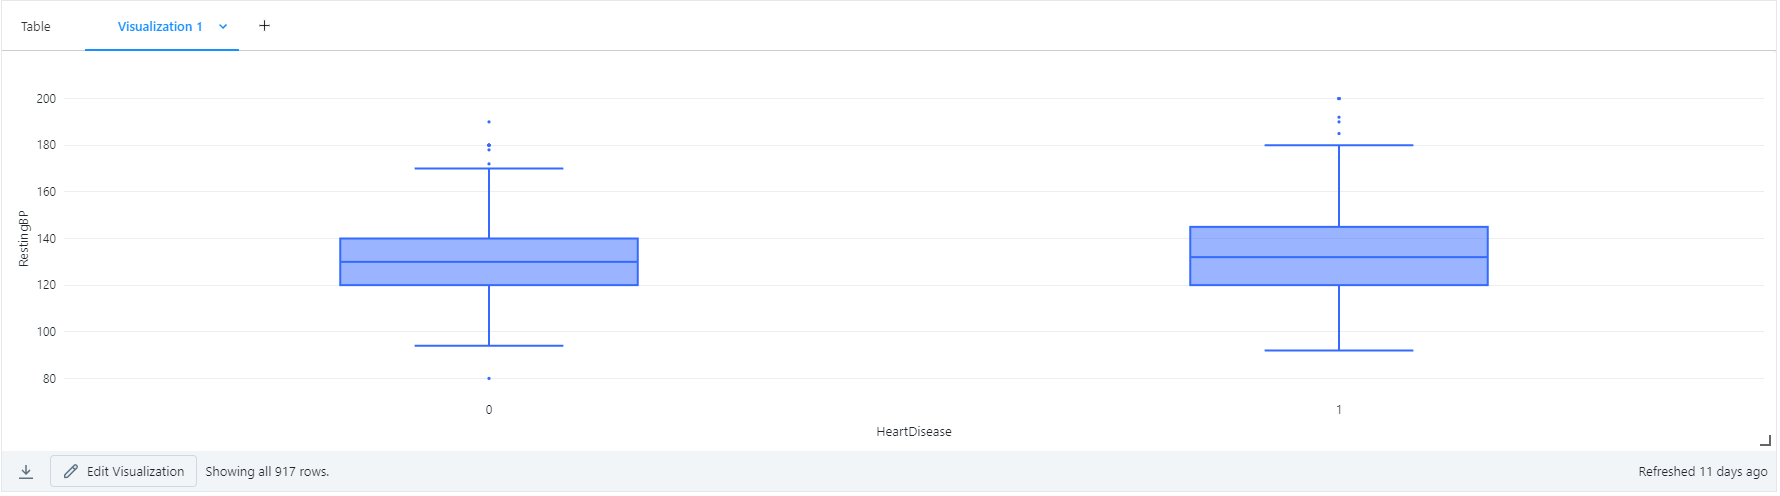

In [ ]:
#display(spdf.select('Cholesterol', 'HeartDisease'))

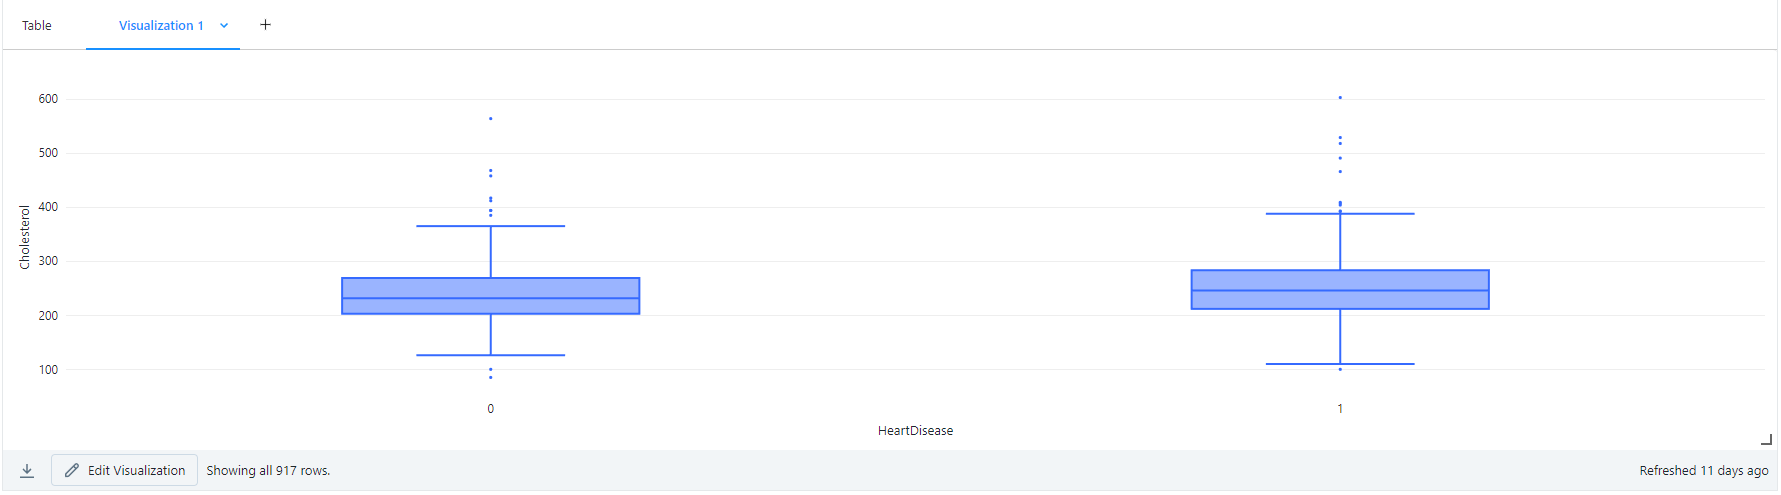

In [ ]:
#display(spdf.select('MaxHR', 'HeartDisease'))

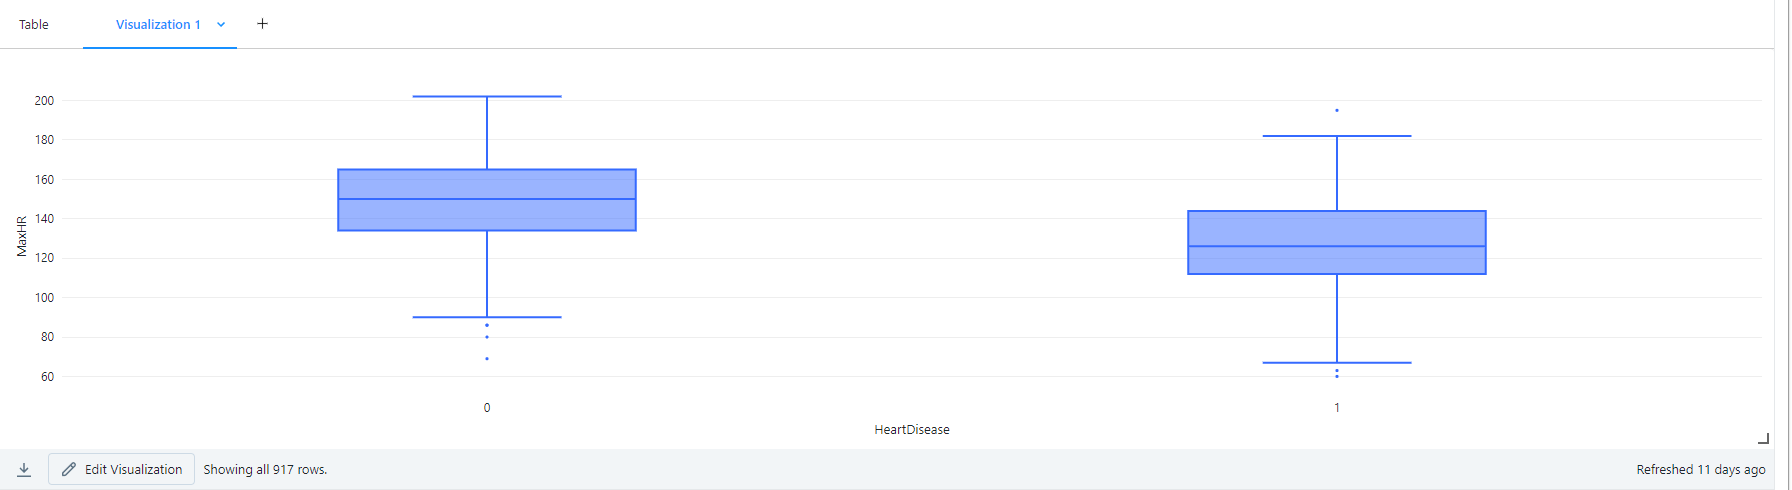

In [ ]:
#display(spdf.select('Oldpeak', 'HeartDisease'))

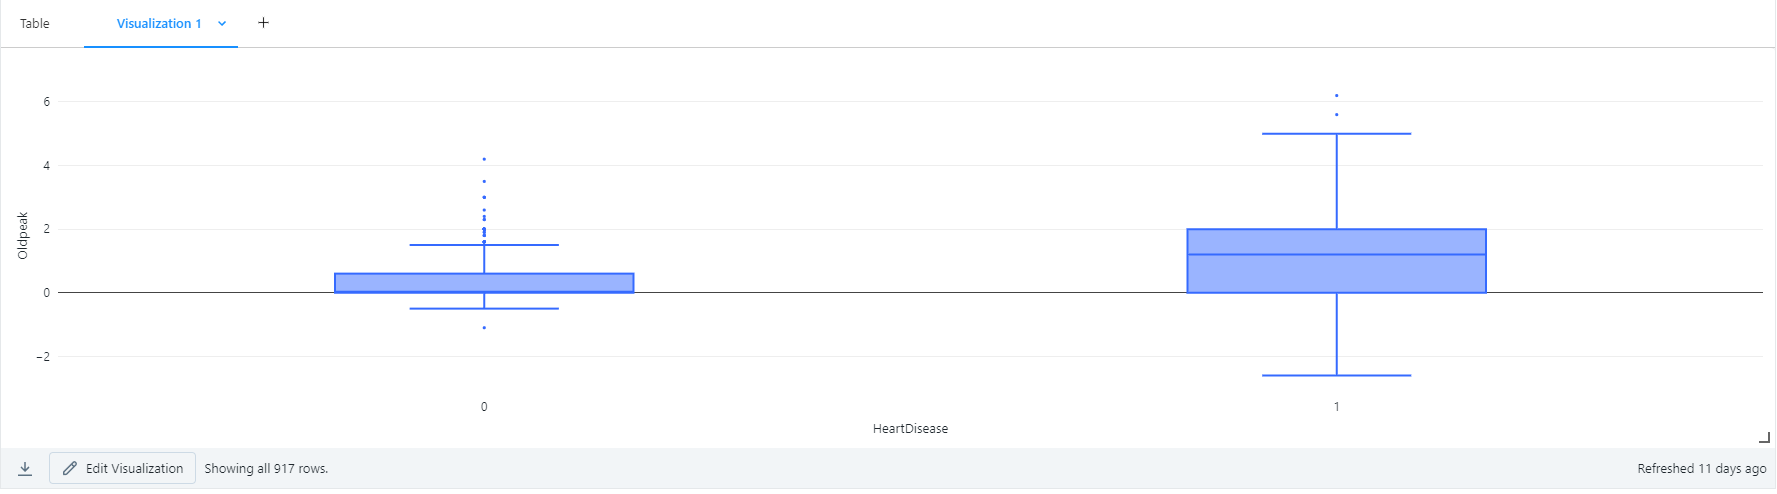

After looking through these boxplots I've noticed significant differences in distribiutions of columns MaxHR, Age and Oldpeak when divided basing on target column.

According to IQR method there are some outliers but since I have no domain knowledge I'm going to leave them as they are. 

#Training

I'll create a final holdout set from 10% of data and for model and hyperparameter selection I'll use 4-fold crossvalidation. I'm also going to impute mean for missing values in cholesterol column. Technically speaking
imputing should happen inside a pipeline passed to crossvalidator so there is no data leakage but including imputer inside of a pipeline causes error when saved pipeline is loaded. Also differences between mean of whole training set and means of each fold's train data will probably be negligible.

In [ ]:
train_spdf, test_spdf = spdf.randomSplit([.9, .1], seed=42)

In [ ]:
imputer = Imputer(inputCol='Cholesterol', outputCol='Cholesterol_imp', missingValue=np.nan)
imputer_fitted = imputer.fit(train_spdf)
train_spdf = imputer_fitted.transform(train_spdf)
test_spdf = imputer_fitted.transform(test_spdf)

In [ ]:
train_spdf = train_spdf.withColumn('cholesterol_imputed', when(col('Cholesterol') == col('Cholesterol_imp'), 0).otherwise(1)).withColumn('Cholesterol', col('Cholesterol_imp')).drop('Cholesterol_imp')
test_spdf = test_spdf.withColumn('cholesterol_imputed', when(col('Cholesterol') == col('Cholesterol_imp'), 0).otherwise(1)).withColumn('Cholesterol', col('Cholesterol_imp')).drop('Cholesterol_imp')

In [ ]:
train_spdf.write.mode('overwrite').format('delta').save('dbfs:/FileStore/tables/heart_train.delta')
test_spdf.write.mode('overwrite').format('delta').save('dbfs:/FileStore/tables/heart_test.delta')

In [ ]:
train_spdf = spark.read.format('delta').load('dbfs:/FileStore/tables/heart_train.delta')
test_spdf = spark.read.format('delta').load('dbfs:/FileStore/tables/heart_test.delta')

In [ ]:
train_spdf.cache()

Out[4]: DataFrame[Age: int, Sex: string, ChestPainType: string, RestingBP: int, Cholesterol: double, FastingBS: int, RestingECG: string, MaxHR: int, ExerciseAngina: string, Oldpeak: double, ST_Slope: string, HeartDisease: int, cholesterol_imputed: int]

In [ ]:
print(train_spdf.rdd.getNumPartitions())
print(test_spdf.rdd.getNumPartitions())

1
1


In [ ]:
numerical = numerical + ['cholesterol_imputed']

#Logistic regression

I'll put all the necessary preprocessing steps and classifier inside a pipeline.

In [ ]:
index_output_cols = [x + 'Index' for x in categorical]
string_indexer = StringIndexer(inputCols=categorical, outputCols=index_output_cols, handleInvalid='skip')

ohe_output_cols = [x + 'OHE' for x in categorical]
ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

assembler_input = ohe_output_cols + numerical + categorical_numeric
vec_assembler = VectorAssembler(inputCols=assembler_input, outputCol='features')

log_reg = LogisticRegression(labelCol='HeartDisease')
log_reg_pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, log_reg])

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='accuracy')

To find optimal hyperparameters I'm going to use Hyperopt. Hyperopt is a bayesian method that finds optimal hyperparameters much faster than grid or random search. Hyperopt will be maximizing accuracy to find these optimal hyperparameters. 

I'll log values of hyperparameters and accuracy achieved for each fitted model using MLFlow. It will allow me to compare these models with eachother and see which values give the best results.

In [ ]:
search_space = {
     'elasticNetParam': hp.uniform('elasticNetParam', 0, 1),
     'regParam': hp.uniform('regParam', 0, 3),
     'threshold': hp.uniform('threshold', 0.3, 0.8)
}

In [ ]:
def objective_log_reg(params):
    
    param_grid = (ParamGridBuilder()
                  .addGrid(log_reg.elasticNetParam, [params['elasticNetParam']])
                  .addGrid(log_reg.regParam, [params['regParam']])
                  .addGrid(log_reg.threshold, [params['threshold']])
                  .build())
    
    cv_pipeline = CrossValidator(estimator=log_reg_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
    
    with mlflow.start_run(nested=True):
        cv_model = cv_pipeline.fit(train_spdf)
        mlflow.log_param('elasticNetParam', params['elasticNetParam'])
        mlflow.log_param('regParam', params['regParam'])
        mlflow.log_param('threshold', params['threshold'])
        mlflow.log_param('model_type', 'logistic_regression')
        mlflow.log_metric('accuracy', cv_model.avgMetrics[0])
        mlflow.log_metric('accuracy_std', cv_model.stdMetrics[0])
    
    return {'loss': -cv_model.avgMetrics[0], 'status': STATUS_OK, 'loss_variance': cv_model.stdMetrics[0]**2}

In [ ]:
trials = Trials()
num_evals = 40

with mlflow.start_run(run_name='logistic_regression_hyperparameter_search') as run:
    best_hyperparam = fmin(fn=objective_log_reg, 
                           space=search_space,
                           algo=tpe.suggest, 
                           max_evals=num_evals,
                           trials=trials,
                           rstate=np.random.default_rng(42),
                           early_stop_fn=no_progress_loss(5))

 25%|██▌       | 10/40 [02:03<06:09, 12.32s/trial, best loss: -0.8546518983771928]


In [ ]:
best_hyperparam

Out[27]: {'elasticNetParam': 0.28735631985323384,
 'regParam': 0.28993393703102743,
 'threshold': 0.5514518773307409}

I'm going to retrain the model with hyperparameters found by Hyperopt. 

I'm also going to log the model, it's hyperparameters and metrics. This time I'm going to measure recall of class 1 which includes false negatives. In case of predicting heart disease false negatives might be the most expensive case of missclassification so I'll pick the best model basing on this metric. 

To avoid unncecessary computation I'm going to take accuracy and std of accuracy from previous run.

In [ ]:
def get_child_runs(run):
    experiment_id = run.info.experiment_id
    filter_string = f'tags.mlflow.rootRunId = "{run.info.run_id}"'
    results = mlflow.search_runs(experiment_ids=[experiment_id], filter_string=filter_string, order_by=['metrics.accuracy DESC'])
    return results

In [ ]:
results = get_child_runs(run)
display(results[:1])

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.accuracy_std,params.regParam,params.elasticNetParam,params.threshold,params.model_type,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookID,tags.mlflow.parentRunId,tags.mlflow.databricks.notebook.commandID,tags.mlflow.rootRunId,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.user,tags.mlflow.databricks.workspaceURL,tags.mlflow.runName,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id
60ee1f87dbe042a59547119e66207748,1078147073770475,FINISHED,dbfs:/databricks/mlflow-tracking/1078147073770475/60ee1f87dbe042a59547119e66207748/artifacts,2022-12-23T18:27:48.278+0000,2022-12-23T18:28:02.836+0000,0.8546518983771928,0.018458627644410155,0.28993393703102743,0.28735631985323384,0.5514518773307409,logistic_regression,1671820082968,7656130984396534,/Users/grudzinski133@gmail.com/Heart disease prediction,/Users/grudzinski133@gmail.com/Heart disease prediction,1078147073770475,45efa013fb704a909a4e1a28449aade2,7457973926010896108_9173097125284166615_efecf4f5c0e24b26a842c1cacca67eb9,45efa013fb704a909a4e1a28449aade2,NOTEBOOK,https://frankfurt.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",grudzinski133@gmail.com,dbc-f0d59ea6-589a.cloud.databricks.com,shivering-fowl-113,"{""cluster_name"":""Trial cluster"",""spark_version"":""12.0.x-cpu-ml-scala2.12"",""node_type_id"":""m5d.large"",""driver_node_type_id"":""m5d.large"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":3,""target_workers"":2}}",1219-180507-lptvxzcy


In [ ]:
def score_and_log_best_model(params):
    
    param_grid = (ParamGridBuilder()
                  .addGrid(log_reg.elasticNetParam, [params['elasticNetParam']])
                  .addGrid(log_reg.regParam, [params['regParam']])
                  .addGrid(log_reg.threshold, [params['threshold']])
                  .build())
    
    #this time I'm setting metric to recall of class 1 
    evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='recallByLabel', metricLabel=1)
    cv_pipeline = CrossValidator(estimator=log_reg_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
       
    
    with mlflow.start_run(run_name='Logistic_regression_best_model') as run:
       
        cv_model = cv_pipeline.fit(train_spdf)
        predictions = cv_model.transform(train_spdf)
        signature = infer_signature(train_spdf.drop('HeartDisease'), predictions.select('prediction'))
    
        mlflow.log_param('elasticNetParam', params['elasticNetParam'])
        mlflow.log_param('regParam', params['regParam'])
        mlflow.log_param('threshold', params['threshold'])
        mlflow.log_param('model_type', 'logistic_regression')
        
        mlflow.log_metric('recallClass1', cv_model.avgMetrics[0])
        mlflow.log_metric('recallClass1Std', cv_model.stdMetrics[0])
        mlflow.log_metric('accuracy', results.iloc[0]['metrics.accuracy'])
        mlflow.log_metric('accuracyStd', results.iloc[0]['metrics.accuracy_std'])
                
        mlflow.spark.log_model(cv_model, 'LogisticRegressionPipeline', signature=signature, input_example=train_spdf.drop('HeartDisease').limit(5).toPandas(), conda_env=mlflow.spark.get_default_conda_env())
        
        mlflow_spark_model_path = f"runs:/{run.info.run_id}/LogisticRegressionPipeline"
        
    return mlflow_spark_model_path

In [ ]:
model_path = score_and_log_best_model(best_hyperparam)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [ ]:
train_spdf = spark.read.format('delta').load('dbfs:/FileStore/tables/heart_train.delta')
test_spdf = spark.read.format('delta').load('dbfs:/FileStore/tables/heart_test.delta')

#Random Forest

In [ ]:
index_output_cols = [x + 'Index' for x in categorical]
string_indexer = StringIndexer(inputCols=categorical, outputCols=index_output_cols, handleInvalid='skip')

assembler_input = index_output_cols + numerical + categorical_numeric
vec_assembler = VectorAssembler(inputCols=assembler_input, outputCol='features')

rf = RandomForestClassifier(labelCol='HeartDisease')
rf_pipeline = Pipeline(stages=[string_indexer, vec_assembler, rf])

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='accuracy')

In [ ]:
impurity_types = ['gini', 'entropy']

search_space = {
     'impurity': hp.choice('impurity', ['gini', 'entropy']),
     'maxDepth': hp.quniform('maxDepth', 3, 25, 1),
     'numTrees': hp.quniform('numTrees', 20, 200, 1),
     'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 40, 1),
     'maxBins': hp.quniform('maxBins', 32, 64, 1)
}

In [ ]:
def objective_rf(params):
    
    impurity_types = ['gini', 'entropy']
    
    param_grid = (ParamGridBuilder()
                  .addGrid(rf.impurity, [params['impurity']])
                  .addGrid(rf.maxDepth, [int(params['maxDepth'])])
                  .addGrid(rf.numTrees, [int(params['numTrees'])])
                  .addGrid(rf.minInstancesPerNode, [int(params['minInstancesPerNode'])])
                  .addGrid(rf.maxBins, [int(params['maxBins'])])
                  .build())
    
    cv_pipeline = CrossValidator(estimator=rf_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
    
    with mlflow.start_run(nested=True):
        cv_model = cv_pipeline.fit(train_spdf)
        mlflow.log_param('impurity', params['impurity'])
        mlflow.log_param('maxDepth', int(params['maxDepth']))
        mlflow.log_param('numTrees', int(params['numTrees']))
        mlflow.log_param('minInstancesPerNode', int(params['minInstancesPerNode']))
        mlflow.log_param('maxBins', int(params['maxBins']))
        mlflow.log_param('model_type', 'random_forest')
        mlflow.log_metric('accuracy', cv_model.avgMetrics[0])
        mlflow.log_metric('accuracy_std', cv_model.stdMetrics[0])
    
    return {'loss': -cv_model.avgMetrics[0], 'status': STATUS_OK, 'loss_variance': cv_model.stdMetrics[0]**2}

In [ ]:
trials = Trials()
num_evals = 80

with mlflow.start_run(run_name='random_forest_hyperparameter_search') as run:
    best_hyperparam = fmin(fn=objective_rf, 
                           space=search_space,
                           algo=tpe.suggest, 
                           max_evals=num_evals,
                           trials=trials,
                           rstate=np.random.default_rng(42),
                           early_stop_fn=no_progress_loss(5))

 14%|█▍        | 11/80 [03:05<19:25, 16.89s/trial, best loss: -0.8726515391640731]


In [ ]:
results = get_child_runs(run)
display(results[:1])

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.accuracy_std,metrics.accuracyStd,metrics.recallClass1Std,metrics.recallClass1,params.impurity,params.maxBins,params.numTrees,params.minInstancesPerNode,params.model_type,params.maxDepth,params.regParam,params.modelType,params.elasticNetParam,params.threshold,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookID,tags.mlflow.parentRunId,tags.sparkDatasourceInfo,tags.mlflow.databricks.notebook.commandID,tags.mlflow.rootRunId,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.user,tags.mlflow.databricks.workspaceURL,tags.mlflow.runName,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id,tags.mlflow.log-model.history
d2a4f6ff2dc049b9b436de1e45b0ebe8,1078147073770475,FINISHED,dbfs:/databricks/mlflow-tracking/1078147073770475/d2a4f6ff2dc049b9b436de1e45b0ebe8/artifacts,2022-12-21T21:15:24.978+0000,2022-12-21T21:15:50.291+0000,0.8726515391640731,0.020970714646940027,null,null,null,gini,55,156,7,random_forest,13,null,null,null,null,1671657350423,7656130984396534,/Users/grudzinski133@gmail.com/Heart disease prediction,/Users/grudzinski133@gmail.com/Heart disease prediction,1078147073770475,fc8d98a268ab425cacbf05566bef7928,"path=mlflowdbfs:/artifacts?run_id=8cd0fcc5de3843f8992f2d09c127d95d&path=/LogisticRegressionPipeline/sparkml/stages/0_CrossValidatorModel_f0bcff19a4c9/bestModel/stages/0_StringIndexer_452480c360a3/data,format=parquet path=mlflowdbfs:/artifacts?run_id=8cd0fcc5de3843f8992f2d09c127d95d&path=/LogisticRegressionPipeline/sparkml/stages/0_CrossValidatorModel_f0bcff19a4c9/bestModel/stages/1_OneHotEncoder_18dab44b0202/data,format=parquet path=mlflowdbfs:/artifacts?run_id=8cd0fcc5de3843f8992f2d09c127d95d&path=/LogisticRegressionPipeline/sparkml/stages/0_CrossValidatorModel_f0bcff19a4c9/bestModel/stages/3_LogisticRegression_75c8523363a4/data,format=parquet path=dbfs:/FileStore/tables/heart_train.delta,version=0,format=delta",3954412676947608652_8011902932625129956_ea0eab3afa5d4878bb9fcf891cce0fab,fc8d98a268ab425cacbf05566bef7928,NOTEBOOK,https://frankfurt.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",grudzinski133@gmail.com,dbc-f0d59ea6-589a.cloud.databricks.com,likeable-mink-348,"{""cluster_name"":""Trial cluster"",""spark_version"":""12.0.x-cpu-ml-scala2.12"",""node_type_id"":""m5d.large"",""driver_node_type_id"":""m5d.large"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":3,""target_workers"":2}}",1219-180507-lptvxzcy,null


In [ ]:
def score_and_log_best_model_rf(params):
    
    param_grid = (ParamGridBuilder()
                  .addGrid(rf.impurity, [impurity_types[params['impurity']]])
                  .addGrid(rf.maxDepth, [int(params['maxDepth'])])
                  .addGrid(rf.numTrees, [int(params['numTrees'])])
                  .addGrid(rf.minInstancesPerNode, [int(params['minInstancesPerNode'])])
                  .addGrid(rf.maxBins, [int(params['maxBins'])])
                  .build())
    
    #this time I'm setting metric to recall of class 1 
    evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='recallByLabel', metricLabel=1)
    cv_pipeline = CrossValidator(estimator=rf_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
       
    
    with mlflow.start_run(run_name='Random_forest_best_model') as run:
       
        cv_pipeline_model = cv_pipeline.fit(train_spdf)
        predictions = cv_pipeline_model.transform(train_spdf)
        signature = infer_signature(train_spdf.drop('HeartDisease'), predictions.select('prediction'))
    
        mlflow.log_param('impurity', impurity_types[params['impurity']])
        mlflow.log_param('maxDepth', int(params['maxDepth']))
        mlflow.log_param('numTrees', int(params['numTrees']))
        mlflow.log_param('minInstancesPerNode', int(params['minInstancesPerNode']))
        mlflow.log_param('maxBins', int(params['maxBins']))
        mlflow.log_param('model_type', 'random_forest')
        
        mlflow.log_metric('recallClass1', cv_pipeline_model.avgMetrics[0])
        mlflow.log_metric('recallClass1Std', cv_pipeline_model.stdMetrics[0])
        mlflow.log_metric('accuracy', results.iloc[0]['metrics.accuracy'])
        mlflow.log_metric('accuracyStd', results.iloc[0]['metrics.accuracy_std'])
                
        mlflow.spark.log_model(cv_pipeline_model, 'RandomForestPipeline', signature=signature, input_example=train_spdf.drop('HeartDisease').limit(5).toPandas(), conda_env=mlflow.spark.get_default_conda_env())
        
        mlflow_spark_model_path = f"runs:/{run.info.run_id}/RandomForest"
        
    return mlflow_spark_model_path

In [ ]:
best_hyperparam

Out[67]: {'impurity': 0,
 'maxBins': 55.0,
 'maxDepth': 13.0,
 'minInstancesPerNode': 7.0,
 'numTrees': 156.0}

In [ ]:
model_path = score_and_log_best_model_rf(best_hyperparam)

#Random Forest with vector indexer

For tree based methods categorical features should be treated differently than numerical ones. I'm using string indexer which maps strings to integers but I don't know if they are then treated by Spark MLLib's algorithms like a categorical feature or numerical one. In a stackoverflow answer one user was claiming that Spark MLLib's algorithms use columns metadata provided by transformers like StringIndexer to determine which columns are categorical but I can't find that information explicitly stated in Spark's documentation. 

VectorIndexer helps index categorical features in datasets of Vectors. It can both automatically decide which features are categorical and convert original values to category indices.

I'm going to see if adding it to the pipeline will improve performance.

In [ ]:
impurity_types = ['gini', 'entropy']

search_space = {
     'impurity': hp.choice('impurity', ['gini', 'entropy']),
     'maxDepth': hp.quniform('maxDepth', 3, 25, 1),
     'numTrees': hp.quniform('numTrees', 20, 200, 1),
     'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 40, 1),
     'maxBins': hp.quniform('maxBins', 32, 64, 1)
}

In [ ]:
index_output_cols = [x + 'Index' for x in categorical]
string_indexer = StringIndexer(inputCols=categorical, outputCols=index_output_cols, handleInvalid='skip')

assembler_input = index_output_cols + numerical + categorical_numeric
vec_assembler = VectorAssembler(inputCols=assembler_input, outputCol='rawFeatures')

vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

rf = RandomForestClassifier(labelCol='HeartDisease')
rf_pipeline = Pipeline(stages=[string_indexer, vec_assembler, vectorIndexer, rf])

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='accuracy')

In [ ]:
def objective_rf(params):
    
    impurity_types = ['gini', 'entropy']
    
    param_grid = (ParamGridBuilder()
                  .addGrid(rf.impurity, [params['impurity']])
                  .addGrid(rf.maxDepth, [int(params['maxDepth'])])
                  .addGrid(rf.numTrees, [int(params['numTrees'])])
                  .addGrid(rf.minInstancesPerNode, [int(params['minInstancesPerNode'])])
                  .addGrid(rf.maxBins, [int(params['maxBins'])])
                  .build())
    
    cv_pipeline = CrossValidator(estimator=rf_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
    
    with mlflow.start_run(nested=True):
        cv_model = cv_pipeline.fit(train_spdf)
        mlflow.log_param('impurity', params['impurity'])
        mlflow.log_param('maxDepth', int(params['maxDepth']))
        mlflow.log_param('numTrees', int(params['numTrees']))
        mlflow.log_param('minInstancesPerNode', int(params['minInstancesPerNode']))
        mlflow.log_param('maxBins', int(params['maxBins']))
        mlflow.log_param('model_type', 'random_forest')
        mlflow.log_metric('accuracy', cv_model.avgMetrics[0])
        mlflow.log_metric('accuracy_std', cv_model.stdMetrics[0])
    
    return {'loss': -cv_model.avgMetrics[0], 'status': STATUS_OK, 'loss_variance': cv_model.stdMetrics[0]**2}

In [ ]:
trials = Trials()
num_evals = 80

despription = 'Using vector indexer instead of string indexer to determine if it makes a difference'

with mlflow.start_run(run_name='random_forest_hyperparameter_search_2', description=despription) as run:
    best_hyperparam = fmin(fn=objective_rf, 
                           space=search_space,
                           algo=tpe.suggest, 
                           max_evals=num_evals,
                           trials=trials,
                           rstate=np.random.default_rng(42),
                           early_stop_fn=no_progress_loss(5))

 10%|█         | 8/80 [03:19<29:58, 24.98s/trial, best loss: -0.8730384379419889]


In [ ]:
best_hyperparam

Out[29]: {'impurity': 1,
 'maxBins': 37.0,
 'maxDepth': 17.0,
 'minInstancesPerNode': 4.0,
 'numTrees': 46.0}

In [ ]:
results = get_child_runs(run)
display(results[:1])

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.accuracy_std,params.impurity,params.maxBins,params.numTrees,params.minInstancesPerNode,params.model_type,params.maxDepth,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookID,tags.mlflow.parentRunId,tags.sparkDatasourceInfo,tags.mlflow.databricks.notebook.commandID,tags.mlflow.rootRunId,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.user,tags.mlflow.databricks.workspaceURL,tags.mlflow.runName,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id,tags.mlflow.note.content
380ab096f00b45fea7b5305b9d10777d,1078147073770475,FINISHED,dbfs:/databricks/mlflow-tracking/1078147073770475/380ab096f00b45fea7b5305b9d10777d/artifacts,2022-12-22T00:00:12.848+0000,2022-12-22T00:00:39.077+0000,0.8730384379419889,0.022700016448510593,entropy,37,46,4,random_forest,17,1671667239209,7656130984396534,/Users/grudzinski133@gmail.com/Heart disease prediction,/Users/grudzinski133@gmail.com/Heart disease prediction,1078147073770475,64062061fbbf4124949eadff512af0a1,"path=dbfs:/FileStore/tables/heart_train.delta,version=0,format=delta",2523564816875397988_6797349034670328562_0ceca3a835064d179c952697d4d0ef4a,64062061fbbf4124949eadff512af0a1,NOTEBOOK,https://frankfurt.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",grudzinski133@gmail.com,dbc-f0d59ea6-589a.cloud.databricks.com,suave-lynx-240,"{""cluster_name"":""Trial cluster"",""spark_version"":""12.0.x-cpu-ml-scala2.12"",""node_type_id"":""m5d.large"",""driver_node_type_id"":""m5d.large"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":3,""target_workers"":2}}",1219-180507-lptvxzcy,null


In [ ]:
def score_and_log_best_model_rf(params):
    
    param_grid = (ParamGridBuilder()
                  .addGrid(rf.impurity, [impurity_types[params['impurity']]])
                  .addGrid(rf.maxDepth, [int(params['maxDepth'])])
                  .addGrid(rf.numTrees, [int(params['numTrees'])])
                  .addGrid(rf.minInstancesPerNode, [int(params['minInstancesPerNode'])])
                  .addGrid(rf.maxBins, [int(params['maxBins'])])
                  .build())
    
    #this time I'm setting metric to recall of class 1 
    evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='recallByLabel', metricLabel=1)
    cv_pipeline = CrossValidator(estimator=rf_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
       
    
    with mlflow.start_run(run_name='Random_forest_best_model_vec_idx') as run:
       
        cv_pipeline_model = cv_pipeline.fit(train_spdf)
        predictions = cv_pipeline_model.transform(train_spdf)
        signature = infer_signature(train_spdf.drop('HeartDisease'), predictions.select('prediction'))
    
        mlflow.log_param('impurity', impurity_types[params['impurity']])
        mlflow.log_param('maxDepth', int(params['maxDepth']))
        mlflow.log_param('numTrees', int(params['numTrees']))
        mlflow.log_param('minInstancesPerNode', int(params['minInstancesPerNode']))
        mlflow.log_param('maxBins', int(params['maxBins']))
        mlflow.log_param('model_type', 'random_forest')
        
        mlflow.log_metric('recallClass1', cv_pipeline_model.avgMetrics[0])
        mlflow.log_metric('recallClass1Std', cv_pipeline_model.stdMetrics[0])
        mlflow.log_metric('accuracy', results.iloc[0]['metrics.accuracy'])
        mlflow.log_metric('accuracyStd', results.iloc[0]['metrics.accuracy_std'])
                
        mlflow.spark.log_model(cv_pipeline_model, 'RandomForestPipeline', signature=signature, input_example=train_spdf.drop('HeartDisease').limit(5).toPandas(), conda_env=mlflow.spark.get_default_conda_env())
        
        mlflow_spark_model_path = f"runs:/{run.info.run_id}/RandomForest"
        
    return mlflow_spark_model_path

In [ ]:
score_and_log_best_model_rf(best_hyperparam)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
Out[47]: 'runs:/07a8c755654545998064ac6811d58b69/RandomForest'

Adding VectorIndexer to the pipeline improved accuracy a tiny bit. It also reduced value of numTrees hyperparameter from 156 to 46 and increased maxDepth to 17 from 13. This trade off results in reduction of model complexity. Although model's accuracy improvment is negligible reduction in model complexity is a gain. I'm not 100% sure this improvment comes from using Vectorindexer, it might also be due to randomness in Hyperopt and crossvalidation but that shouldn't be the case because I used the same seeds and training data.

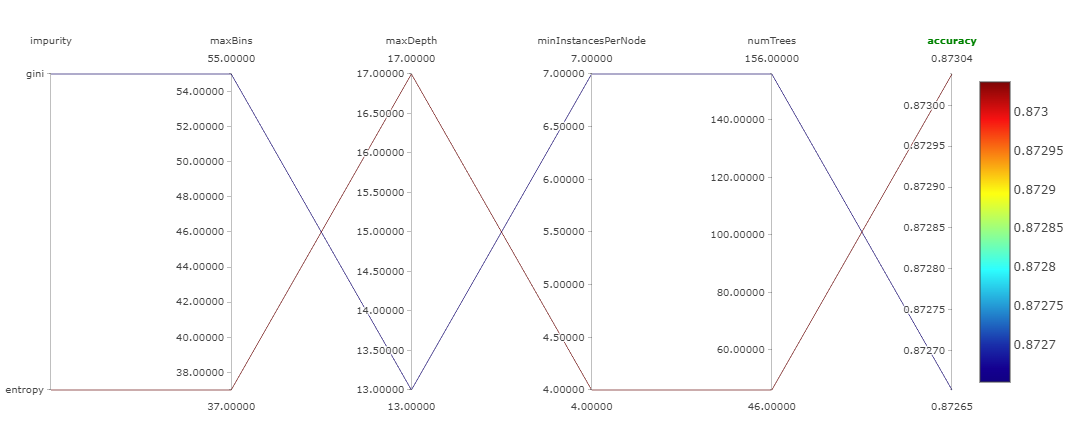

I'm going to train pipeline with VectorIndexer included using hyperparameters from the best run in first Random Forest experiment and measure it's accuracy.

In [ ]:
param_grid = (ParamGridBuilder()
              .addGrid(rf.impurity, ['gini'])
              .addGrid(rf.maxDepth, [13])
              .addGrid(rf.numTrees, [156])
              .addGrid(rf.minInstancesPerNode, [7])
              .addGrid(rf.maxBins, [55])
              .build())

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='accuracy', metricLabel=1)
cv_pipeline = CrossValidator(estimator=rf_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)

pipeline_fitted = cv_pipeline.fit(train_spdf)

Result is different from that obtained during first experiment suggesting that VectorIndexer changed model's behaviour during training. Again this might be due to randomness in CrossValidator but I used the same seed so it shouldn't be the case.

From now on I'm going to include VectorIndexer in my pipelines when training tree based models.

In [ ]:
pipeline_fitted.avgMetrics

Out[10]: [0.8701632814221714]

# XGBoost

In [ ]:
search_space = {
     'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),
     'max_depth': hp.quniform('max_depth', 5, 25, 1),
     'min_child_weight': hp.uniform('min_child_weight', 1, 40),
     'subsample': hp.uniform('subsample', 0.4, 1),
     'gamma': hp.uniform('gamma', 0, 20)
}

In [ ]:
index_output_cols = [x + 'Index' for x in categorical]
string_indexer = StringIndexer(inputCols=categorical, outputCols=index_output_cols, handleInvalid='skip')

assembler_input = index_output_cols + numerical + categorical_numeric
vec_assembler = VectorAssembler(inputCols=assembler_input, outputCol='rawFeatures')

vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

xgb_classifier = SparkXGBClassifier(num_workers=1, label_col="HeartDisease", missing=0.0)
xgb_pipeline = Pipeline(stages=[string_indexer, vec_assembler, vectorIndexer, xgb_classifier])

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='accuracy')

In [ ]:
def objective_xgb(params):

    param_grid = (ParamGridBuilder()
                  .addGrid(xgb_classifier.learning_rate, [params['learning_rate']])
                  .addGrid(xgb_classifier.max_depth, [int(params['max_depth'])])
                  .addGrid(xgb_classifier.min_child_weight, [params['min_child_weight']])
                  .addGrid(xgb_classifier.subsample, [params['subsample']])
                  .addGrid(xgb_classifier.gamma, [params['gamma']])
                  .build())
    
    cv_pipeline = CrossValidator(estimator=xgb_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
    
    with mlflow.start_run(nested=True):
        cv_model = cv_pipeline.fit(train_spdf)
        mlflow.log_param('learning_rate', params['learning_rate'])
        mlflow.log_param('max_depth', int(params['max_depth']))
        mlflow.log_param('min_child_weight', params['min_child_weight'])
        mlflow.log_param('subsample', params['subsample'])
        mlflow.log_param('gamma', params['gamma'])
        mlflow.log_param('model_type', 'XGBoost')
        mlflow.log_metric('accuracy', cv_model.avgMetrics[0])
        mlflow.log_metric('accuracy_std', cv_model.stdMetrics[0])
    
    return {'loss': -cv_model.avgMetrics[0], 'status': STATUS_OK, 'loss_variance': cv_model.stdMetrics[0]**2}

Sometimes I get warnings that XGBoost loaded a model with Scikit-Learn interface but these runs finish without errors so I it's probably just a bug

In [ ]:
trials = Trials()
num_evals = 80

with mlflow.start_run(run_name='xgboost_hyperparameter_search') as run:
    best_hyperparam = fmin(fn=objective_xgb, 
                           space=search_space,
                           algo=tpe.suggest, 
                           max_evals=num_evals,
                           trials=trials,
                           rstate=np.random.default_rng(42),
                           early_stop_fn=no_progress_loss(5))

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]/databricks/.python_edge_libs/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")

 11%|█▏        | 9/80 [05:23<34:25, 29.09s/trial, best loss: -0.8749037914163253]/databricks/.python_edge_libs/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")

 12%|█▎        | 10/80 [05:51<40:58, 35.12s/trial, best loss: -0.8749037914163253]


In [ ]:
results = get_child_runs(run)
display(results[:1])

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.accuracy_std,params.gamma,params.learning_rate,params.min_child_weight,params.model_type,params.subsample,params.max_depth,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookID,tags.mlflow.parentRunId,tags.mlflow.databricks.notebook.commandID,tags.mlflow.rootRunId,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.user,tags.mlflow.databricks.workspaceURL,tags.mlflow.runName,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id
556a02694ace400291f6a2a4e454faca,1078147073770475,FINISHED,dbfs:/databricks/mlflow-tracking/1078147073770475/556a02694ace400291f6a2a4e454faca/artifacts,2022-12-23T18:03:13.719+0000,2022-12-23T18:03:42.963+0000,0.8749037914163253,0.021926818430044126,6.763311629907447,0.10390096743058716,4.769141181403357,XGBoost,0.7017422527968891,11,1671818623102,7656130984396534,/Users/grudzinski133@gmail.com/Heart disease prediction,/Users/grudzinski133@gmail.com/Heart disease prediction,1078147073770475,b8a8e2a16a0448a28fd2d250fed68fc5,7457973926010896108_5677931569822596783_fc7171388fb84701be9f15b43941f1f4,b8a8e2a16a0448a28fd2d250fed68fc5,NOTEBOOK,https://frankfurt.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",grudzinski133@gmail.com,dbc-f0d59ea6-589a.cloud.databricks.com,zealous-stoat-626,"{""cluster_name"":""Trial cluster"",""spark_version"":""12.0.x-cpu-ml-scala2.12"",""node_type_id"":""m5d.large"",""driver_node_type_id"":""m5d.large"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":3,""target_workers"":2}}",1219-180507-lptvxzcy


In [ ]:
def score_and_log_best_model_xgb(params):
    
    param_grid = (ParamGridBuilder()
                  .addGrid(xgb_classifier.learning_rate, [params['learning_rate']])
                  .addGrid(xgb_classifier.max_depth, [int(params['max_depth'])])
                  .addGrid(xgb_classifier.min_child_weight, [params['min_child_weight']])
                  .addGrid(xgb_classifier.subsample, [params['subsample']])
                  .addGrid(xgb_classifier.gamma, [params['gamma']])
                  .build())
    
    #this time I'm setting metric to recall of class 1 
    evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricName='recallByLabel', metricLabel=1)
    cv_pipeline = CrossValidator(estimator=xgb_pipeline, evaluator=evaluator, numFolds=4, seed=42, estimatorParamMaps=param_grid)
       
    
    with mlflow.start_run(run_name='XGB_best_model') as run:
       
        cv_pipeline_model = cv_pipeline.fit(train_spdf)
        predictions = cv_pipeline_model.transform(train_spdf)
        signature = infer_signature(train_spdf.drop('HeartDisease'), predictions.select('prediction'))
    
        mlflow.log_param('learning_rate', params['learning_rate'])
        mlflow.log_param('max_depth', int(params['max_depth']))
        mlflow.log_param('min_child_weight', params['min_child_weight'])
        mlflow.log_param('subsample', params['subsample'])
        mlflow.log_param('gamma', params['gamma'])
        mlflow.log_param('model_type', 'XGBoost')
        
        mlflow.log_metric('recallClass1', cv_pipeline_model.avgMetrics[0])
        mlflow.log_metric('recallClass1Std', cv_pipeline_model.stdMetrics[0])
        mlflow.log_metric('accuracy', results.iloc[0]['metrics.accuracy'])
        mlflow.log_metric('accuracyStd', results.iloc[0]['metrics.accuracy_std'])
                
        mlflow.spark.log_model(cv_pipeline_model, 'XGBPipeline', signature=signature, input_example=train_spdf.drop('HeartDisease').limit(5).toPandas(), conda_env=mlflow.spark.get_default_conda_env())
        
        mlflow_spark_model_path = f"runs:/{run.info.run_id}/XGBipeline"
        
    return mlflow_spark_model_path

In [ ]:
best_hyperparam

Out[13]: {'gamma': 6.763311629907447,
 'learning_rate': 0.10390096743058716,
 'max_depth': 11.0,
 'min_child_weight': 4.769141181403357,
 'subsample': 0.7017422527968891}

In [ ]:
model_path = score_and_log_best_model_xgb(best_hyperparam)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


XGBoost got the best results both on accuracy and recall of class 1.

XGBoost will be my final model. I'm going to test it's performance on holdout test set and, register it to mlflow model's registery and set it's stage to production.

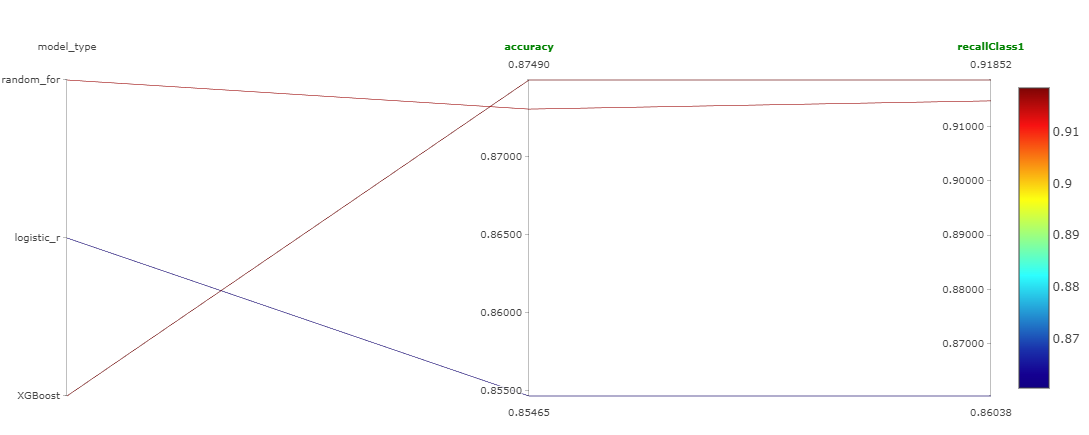

In [ ]:
best_model_path = 'runs:/18cffdfe0033468db546265fdabcdc47/XGBPipeline'

loaded_model = mlflow.spark.load_model(best_model_path)

predictions = loaded_model.transform(test_spdf)

2022/12/29 15:32:45 INFO mlflow.spark: 'runs:/18cffdfe0033468db546265fdabcdc47/XGBPipeline' resolved as 'dbfs:/databricks/mlflow-tracking/1078147073770475/18cffdfe0033468db546265fdabcdc47/artifacts/XGBPipeline'
/databricks/.python_edge_libs/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [ ]:
display(predictions)

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,cholesterol_imputed,ChestPainTypeIndex,SexIndex,RestingECGIndex,ExerciseAnginaIndex,ST_SlopeIndex,rawFeatures,features,rawPrediction,prediction,probability
31,M,ASY,120,270.0,0,Normal,153,Y,1.5,Flat,1,0,0.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 12, indices -> List(3, 5, 6, 7, 8, 9), values -> List(1.0, 31.0, 120.0, 270.0, 153.0, 1.5))","Map(vectorType -> sparse, length -> 12, indices -> List(3, 5, 6, 7, 8, 9), values -> List(1.0, 31.0, 120.0, 270.0, 153.0, 1.5))","Map(vectorType -> dense, length -> 2, values -> List(-1.9479680061340332, 1.9479680061340332))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.12477511167526245, 0.8752248883247375))"
32,M,ASY,118,529.0,0,Normal,130,N,0.0,Flat,1,0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 12, indices -> List(5, 6, 7, 8), values -> List(32.0, 118.0, 529.0, 130.0))","Map(vectorType -> sparse, length -> 12, indices -> List(5, 6, 7, 8), values -> List(32.0, 118.0, 529.0, 130.0))","Map(vectorType -> dense, length -> 2, values -> List(-1.8679745197296143, 1.8679745197296143))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.1337762475013733, 0.8662237524986267))"
37,M,NAP,130,194.0,0,Normal,150,N,0.0,Up,0,0,1.0,0.0,0.0,0.0,1.0,"Map(vectorType -> sparse, length -> 12, indices -> List(0, 4, 5, 6, 7, 8), values -> List(1.0, 1.0, 37.0, 130.0, 194.0, 150.0))","Map(vectorType -> sparse, length -> 12, indices -> List(0, 4, 5, 6, 7, 8), values -> List(1.0, 1.0, 37.0, 130.0, 194.0, 150.0))","Map(vectorType -> dense, length -> 2, values -> List(2.862276792526245, -2.862276792526245))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9459498524665833, 0.05405016988515854))"
38,M,ASY,110,289.0,0,Normal,105,Y,1.5,Down,1,0,0.0,0.0,0.0,1.0,2.0,"Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 1.0, 2.0, 38.0, 110.0, 289.0, 105.0, 1.5, 0.0, 0.0))","Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 1.0, 2.0, 38.0, 110.0, 289.0, 105.0, 1.5, 0.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(-2.189321994781494, 2.189321994781494))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.10071343183517456, 0.8992865681648254))"
39,M,NAP,120,339.0,0,Normal,170,N,0.0,Up,0,0,1.0,0.0,0.0,0.0,1.0,"Map(vectorType -> sparse, length -> 12, indices -> List(0, 4, 5, 6, 7, 8), values -> List(1.0, 1.0, 39.0, 120.0, 339.0, 170.0))","Map(vectorType -> sparse, length -> 12, indices -> List(0, 4, 5, 6, 7, 8), values -> List(1.0, 1.0, 39.0, 120.0, 339.0, 170.0))","Map(vectorType -> dense, length -> 2, values -> List(2.693474531173706, -2.693474531173706))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9366405010223389, 0.06335950642824173))"
41,M,ASY,104,243.72238372093022,0,ST,111,N,0.0,Up,0,1,0.0,0.0,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 41.0, 104.0, 243.72238372093022, 111.0, 0.0, 1.0, 0.0))","Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 41.0, 104.0, 243.72238372093022, 111.0, 0.0, 1.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.7310901284217834, 0.7310901284217834))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.3249555230140686, 0.6750444769859314))"
41,M,NAP,130,214.0,0,LVH,168,N,2.0,Flat,0,0,1.0,0.0,1.0,0.0,0.0,"Map(vectorType -> dense, length -> 12, values -> List(1.0, 0.0, 1.0, 0.0, 0.0, 41.0, 130.0, 214.0, 168.0, 2.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 12, values -> List(1.0, 0.0, 1.0, 0.0, 0.0, 41.0, 130.0, 214.0, 168.0, 2.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.4250965416431427, 0.4250965416431427))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.3952978253364563, 0.6047021746635437))"
42,F,ASY,102,265.0,0,LVH,122,N,0.6,Flat,0,0,0.0,1.0,1.0,0.0,0.0,"Map(vectorType -> dense, length -> 12, 

On test set accuracy goes down by almost 6 percentage points but recall of class 1 gose up by over 5 percentage points.

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', metricLabel=1, metricName='accuracy')

accuracy = evaluator.evaluate(predictions)

evaluator.setMetricName('recallByLabel')

recall_c1 = evaluator.evaluate(predictions)

print(f'Accuracy on test set = {accuracy:.2f}')
print(f'Recall of class 1 on test set = {recall_c1:.2f}')

Accuracy on test set = 0.82
Recall of class 1 on test set = 0.97


In [ ]:
model_details = mlflow.register_model(model_uri=best_model_path, name='HeartDiseaseClassifier')

Successfully registered model 'HeartDiseaseClassifier'.
2022/12/29 15:49:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HeartDiseaseClassifier, version 1
Created version '1' of model 'HeartDiseaseClassifier'.


In [ ]:
client = MlflowClient()
#general model description
client.update_registered_model(
    name=model_details.name,
    description="This model predicts if patient have a heart disease based on patient's medical information."
)
#version specific description
client.update_model_version(
    name=model_details.name,
    version=model_details.version,
    description="This model version was built using XGB.spark."
)

Out[21]: <ModelVersion: creation_timestamp=1672328970265, current_stage='Production', description='This model version was built using XGB.spark.', last_updated_timestamp=1672329434083, name='HeartDiseaseClassifier', run_id='18cffdfe0033468db546265fdabcdc47', run_link='', source='dbfs:/databricks/mlflow-tracking/1078147073770475/18cffdfe0033468db546265fdabcdc47/artifacts/XGBPipeline', status='READY', status_message='', tags={}, user_id='5196605108336090', version='1'>

In [ ]:
client.transition_model_version_stage(
    name=model_details.name,
    version=model_details.version,
    stage="Production"
)

Out[20]: <ModelVersion: creation_timestamp=1672328970265, current_stage='Production', description='This model version was built using XGB.spark.', last_updated_timestamp=1672329395508, name='HeartDiseaseClassifier', run_id='18cffdfe0033468db546265fdabcdc47', run_link='', source='dbfs:/databricks/mlflow-tracking/1078147073770475/18cffdfe0033468db546265fdabcdc47/artifacts/XGBPipeline', status='READY', status_message='', tags={}, user_id='5196605108336090', version='1'>